In [1]:
# Stock Sentiment Analysis From Finviz

# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
# Module for sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer





In [4]:
# Finviz URL to get access the page of a given stock
finwiz_url = 'https://finviz.com/quote.ashx?t='


# Extract the date, the time and news headline (stored in news table) for each row
# in the HTML file and perform sentiment analysis
# Store news-table from Finviz into a Python Dictionary

news_tables = {}
tickers = ['AMZN', 'TSLA', 'NIO', 'WKHS']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url, headers={'user-agent': 'my-app/0.0.1'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the soup object and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [ ]:
# Read one single day of headlines for 'AMZN'
amzn = news_tables['AMZN']

# Get all the table rows tagged in HTML with <tr> into amzn_tr
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    a_text = table_row.a.text  # Read the text of the element 'a' into 'link_text'
    td_text = table_row.td.text # Read the text of the element 'td' into 'data_text'
    print(a_text)  # Print contents of 'link_text'
    print(td_text)  # Print contents of 'data_text'
    if i == 3:  # Exit after printing 4 rows of data
        break


In [5]:
# Parse the Date, Time and News Headlines into a list
parsed_news = []

# Loop through the news
for file_name, news_table in news_tables.items():
    # Loop through all tr tags in 'news table'
    for x in news_table.findAll('tr'):
        text = x.a.get_text() # Read the text from each tr tag into text and get text from a only
        # Split text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the length of 'data_scrape' is 1, load 'time' as the only element


        if len(date_scrape) == 1:
            time = date_scrape[0]

        # Else load 'date' as the first element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the first '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headlines as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

  ticker        date     time  \
0   AMZN  2020-07-03  03:21PM   
1   AMZN  2020-07-03  08:13AM   
2   AMZN  2020-07-03  08:08AM   
3   AMZN  2020-07-03  07:00AM   
4   AMZN  2020-07-03  06:49AM   

                                            headline    neg    neu    pos  \
0                        2 Hot Stocks to Buy in July  0.000  1.000  0.000   
1  Don't Expect Explosive Growth From the Amazon ...  0.201  0.643  0.156   
2  5 Cloud Stocks Set to Rally in the Second Half...  0.000  1.000  0.000   
3        Balkanization Is Bad for Facebooks Business  0.412  0.588  0.000   
4  Zooms Newest Challenger: Budding Internet Tyco...  0.000  0.824  0.176   

   compound  
0    0.0000  
1   -0.1240  
2    0.0000  
3   -0.5423  
4    0.1280  


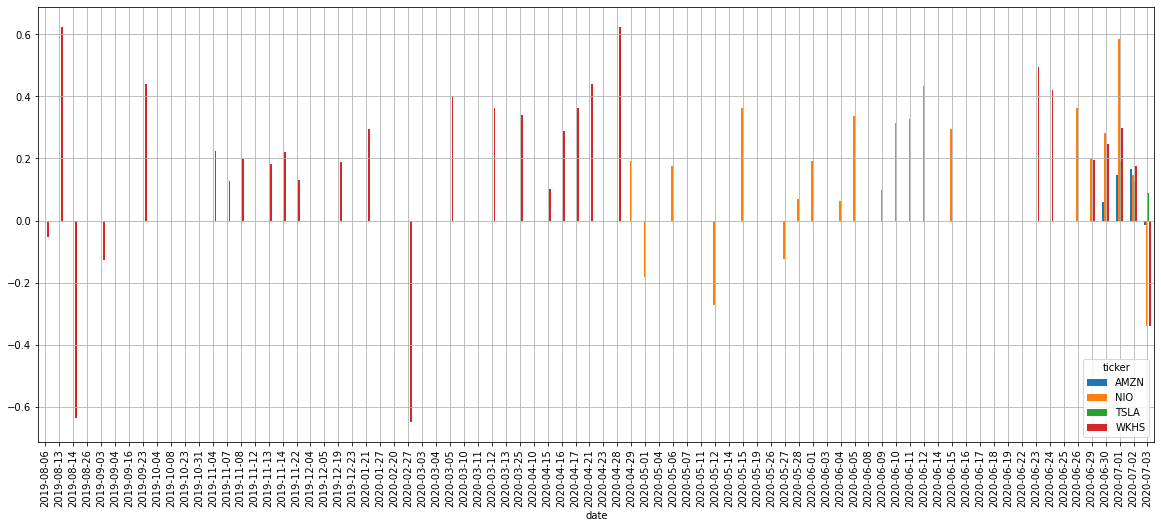

In [11]:
# Run Sentiment Analysis with Vader

# Initiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called parsed_and_scored_news
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns )

# Iterate through the headlines and get the polarity scores using Vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

print(parsed_and_scored_news.head())

# Plot Bar Charts of the sentiment scores for each day
# We are plotting the average of sentiment scores
# For all news headlines collected during each date

plt.rcParams['figure.figsize'] = [20, 8]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'column' axis
mean_scores = mean_scores.xs('compound', axis='columns').transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind='bar')
plt.grid()